# Denoised and Pick DAS

This notebook test the ensemble deep learning picker from Yuan et al, 2023 on DAS data, whether it is raw data or denoised using MAE.

**Marine Denolle** and **Qibin Shi**

Import modules


This notebook assumes that your environment has:
1. SeisBench
2. ELEP. Get it from there https://github.com/congcy/ELEP and install it

In [62]:
import sys
sys.path.append("../src/denoiser/")
sys.path.append("../src/ensemble_picker/")
sys.path.append("../models/")

import gc
import h5py
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.signal import filtfilt, butter
from torch.utils.data import DataLoader

# This package
from das_denoise_models import unet, dataflow, datalabel
from das_denoise_training import train_augmentation
from das_util import try_gpu

# seisbench
import seisbench.models as sbm

# some ELEP functions
from mbf_elep_func import apply_mbf

In [33]:
from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func
from ELEP.elep.trigger_func import picks_summary_simple

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter 

## Get the data

where is the data ?

In [34]:
! du -sh /fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023*

8.3G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_22.hdf5
3.8G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_29.hdf5
5.2G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_12.hdf5
5.4G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_16.hdf5
11G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_08_18.hdf5
24G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_02.hdf5
24G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_11.hdf5
16G	/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_11_14.hdf5


### Prepare and read Data

In [91]:
sampling_rate = 25 # number of points per second
dchan = 10 # channel spacing in mebers
chan_max = 6000  # maximum channel to trim the data

### Now we read data that was prepared as numpy arrays, combining 2 cables.

We need to recover the absolute start time of each of the files in order to assign ORIGIN TIME and TRAVEL TIME of our picks.

In [97]:
### Read (change the file to the latest if needed)
data_terra = '/fd1/QibinShi_data/akdas/qibin_data/TERRAtill2023_07_29.hdf5'
data_kkfls = '/fd1/QibinShi_data/akdas/qibin_data/KKFLStill2023_07_29.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['quake'][:]
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['quake'][:]
    
# combine both arrays
rawdata = np.append(quake2[:,0:chan_max:-1,:], quake1[:,:chan_max,:], axis=1)

In [98]:
print(quake2[:,:chan_max,:].shape)
print(rawdata.shape)

(90, 6000, 1500)
(180, 6000, 1500)


In [99]:
print(rawdata.shape)
print(f'there are  {rawdata.shape[0]:d}  events, for {rawdata.shape[1]:d} channels, and {rawdata.shape[2]:d} samples in time')

(180, 6000, 1500)
there are  180  events, for 6000 channels, and 1500 samples in time


### Filter data & normalize

In [100]:
### Filter
b, a = butter(4, (0.5, 12), fs=sampling_rate, btype='bandpass')
filtered_data = filtfilt(b, a, rawdata, axis=2)

Plot the data .  Take the example of the 5th event

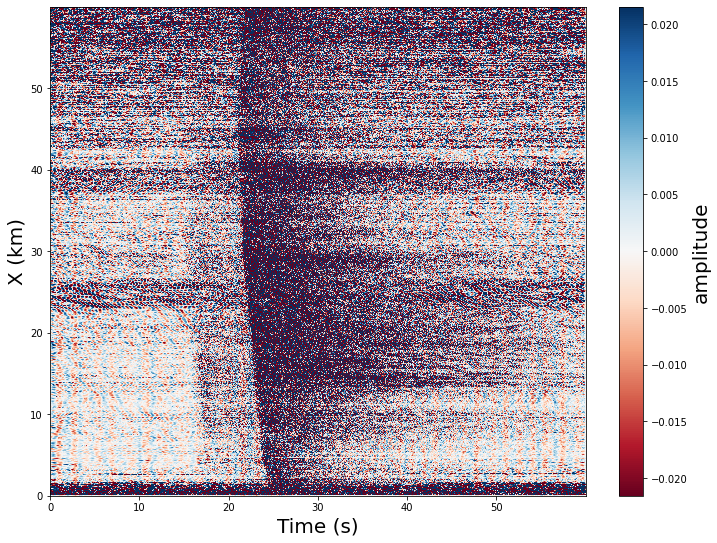

In [101]:
### visualize example data
time_data = filtered_data[5]
max_amp = np.median(np.fabs(time_data))*2
x, y=np.arange(time_data.shape[1]), np.arange(time_data.shape[0])

plt.figure(figsize=(12, 9)); cmap=plt.cm.get_cmap('RdBu')
plt.pcolormesh(x, y, time_data, shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap)
plt.xticks(np.arange(0, 1500, 250), np.arange(0, 1500/sampling_rate, 250/sampling_rate).astype(int))
plt.yticks(np.arange(0, chan_max, 1000), (np.arange(0, dchan*chan_max, 1000*dchan)/1000).astype(int))
plt.xlabel("Time (s)", fontsize=20); plt.ylabel("X (km)", fontsize=20)
cbr=plt.colorbar(); cbr.set_label('amplitude', fontsize = 20)

### Some useful functions for DAS processing

In [102]:
def process_3d_array(arr, len1=1500, len2=1500):
    """convert to numpy array"""
    arr = np.array(arr)
    
    """Ensure the array has at least len1 rows and len2 columns"""
    slices, rows, cols = arr.shape
    arr = arr[:, :min(rows, len1), :min(cols, len2)]
    
    """Pad zeros if it has fewer than len1 rows or len2 columns"""
    if rows < len1 or cols < len2:
        padding_rows = max(len1 - rows, 0)
        padding_cols = max(len2 - cols, 0)
        arr = np.pad(arr, ((0, 0), (0, padding_rows), (0, padding_cols)), 'constant')
    
    return arr


def Denoise_initMAE(data, weight_path, devc, device_id=[0,1,2,3], repeat=4, use_att=False):
    """ This function do the following (it does NOT filter data):
    1) load the denoiser
    2) call Denoise function
    """   
    """ Initialize the U-net model """
    model = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=use_att)
    model = nn.DataParallel(model, device_ids=device_id)
    model.to(devc)
    model.load_state_dict(torch.load(weight_path))
    model.eval() 
    
    oneDenoise, mulDenoise = Denoise(data, model, devc)
    
    return oneDenoise, mulDenoise


def Denoise_largeDAS(data, model_func, devc, repeat=4, norm_batch=True):
    """ This function do the following (it does NOT filter data):
    1) split into multiple 1500-channel segments
    2) call Denoise function for each segments
    3) merge all segments
    
    data: 2D -- [channel, time]
    output: 2D, but padded 0 to have multiple of 1500 channels
    
    This code was primarily designed for the Alaska DAS, but applicable to other networks
    """ 
    nchan = len(data)
    ntime = len(data[0])
    
    if (nchan // 1500) == 0:
        n_seg = nchan // 1500
    else:
        n_seg = nchan // 1500 + 1
        
    full_len = n_seg * 1500
    
    pad_data = process_3d_array(data[np.newaxis,:,:], len1=full_len)
    data3d = pad_data.reshape((-1, 1500, 1500))
    
    oneDenoise, mulDenoise = Denoise(data3d, model_func, devc, repeat=repeat, norm_batch=norm_batch)
    
    oneDenoise2d = oneDenoise.reshape((full_len, 1500))[:nchan, :ntime]
    mulDenoise2d = mulDenoise.reshape((full_len, 1500))[:nchan, :ntime]
    
    return oneDenoise2d, mulDenoise2d
    

def Denoise(data, model_func, devc, repeat=4, norm_batch=False):
    """ This function do the following (it does NOT initialize model):

    1) normalized the data
    2) ensure the data format, precision and size
    3) denoise and scale back the output amplitude
    """ 
    
    """ convert to torch tensors """
    if norm_batch:
        scale = np.std(data[-1]) + 1e-7  ### Avoid potentially bad beginning channels
    else:
        scale = np.std(data, axis=(1,2), keepdims=True) + 1e-7
        
    data_norm = data / scale  ## standard scaling
    arr = process_3d_array(data_norm.astype(np.float32))
    X = torch.from_numpy(arr).to(devc)
    
    """ denoise - deploy """
    with torch.no_grad():
        oneDenoise = model_func(X)
        mulDenoise = oneDenoise
        
        for i in range(repeat-1):
            mulDenoise = model_func(mulDenoise)

    """ convert back to numpy """
    oneDenoise = oneDenoise.to('cpu').numpy() * scale
    mulDenoise = mulDenoise.to('cpu').numpy() * scale
    
    return oneDenoise[:, :len(data[0]), :len(data[0][0])], mulDenoise[:, :len(data[0]), :len(data[0][0])]
    
    
def vizRawDenoise(in_data, oneDenoise, mulDenoise, sample_rate=25, dchan=10, index=[0,1], model="MAE"):
    """
    in_data, oneDenoise, mulDenoise: 3D -- [event, channel, time]
    index: list, subset of the events
    model: string, descriptions about the model
    """
    len1, len2 = oneDenoise[0].shape[0], oneDenoise[0].shape[1]
    x, y = np.arange(len2), np.arange(len1)
    rawdata = process_3d_array(in_data, len1=len1, len2=len2)

    for j in index:
        bound = np.median(np.fabs(in_data[j]))*2
        fig, ax = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

        img=ax[0].pcolormesh(x, y, rawdata[j], shading='auto', vmin=-bound, vmax=bound, cmap=plt.cm.get_cmap('RdBu'))
        ax[1].pcolormesh(x, y, oneDenoise[j], shading='auto',  vmin=-bound, vmax=bound, cmap=plt.cm.get_cmap('RdBu'))
        ax[2].pcolormesh(x, y, mulDenoise[j], shading='auto', vmin=-bound, vmax=bound, cmap=plt.cm.get_cmap('RdBu'))

        ax[0].set_title("Raw data #"+str(j), fontsize=24)
        ax[1].set_title(model+" 1-time denoised", fontsize=24)
        ax[2].set_title(model+" multi-time denoised", fontsize=24)
        ax[0].set_ylabel('Distance (km)', fontsize=24)

        plt.colorbar(img, ax=ax[2])

        for i in range(3):
            ax[i].set_xlabel('Time (s)', fontsize=24)
            ax[i].set_xticks(np.arange(0, 250*(len2//250), 250)) 
            ax[i].set_xticklabels(np.arange(0, 250*(len2//250)/sample_rate, 250/sample_rate).astype(int))
            ax[i].set_yticks(np.arange(0, 200*(len1//200), 200))
            ax[i].set_yticklabels((np.arange(0, dchan*200*(len1//200), 200*dchan)/1000).astype(int))

### Prepare data to be denoised

Data smaller than 1500x1500 will be padded with 0. For deploying this denoiser, enter the entire image (not masked).

In [105]:
""" what data to denoise """
in_data = filtered_data#[:100,500:1000,200:1000]

### Find models

In [103]:
""" what device to deploy the model """
devc = try_gpu(i=0)

""" what model to use """
# U-net trained on pure raw (scaled) data (input and output)
model_path_raw2raw='../models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2raw.pt'
# U-net trained on raw input data and FK filtered output data
model_path_fk2fk  ='../models/checkpoint_noatt_LRdecays0.8_mask0.5_fk2fk.pt'
# U-net trained on raw data input and FK-filtered data ouput.
model_path_raw2fk ='../models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2fk_taperTo_0.3.pt'

### Denoise strategy -- Initialize model and apply repeatedly

In [104]:
""" Initialize the U-net model """
model_raw2raw = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_raw2raw = nn.DataParallel(model_raw2raw, device_ids=[0,1,2,3])
model_raw2raw.to(devc)
model_raw2raw.load_state_dict(torch.load(model_path_raw2raw))
model_raw2raw.eval()

model_fk2fk = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_fk2fk = nn.DataParallel(model_fk2fk, device_ids=[0,1,2,3])
model_fk2fk.to(devc)
model_fk2fk.load_state_dict(torch.load(model_path_fk2fk))
model_fk2fk.eval()

model_raw2fk = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_raw2fk = nn.DataParallel(model_raw2fk, device_ids=[0,1,2,3])
model_raw2fk.to(devc)
model_raw2fk.load_state_dict(torch.load(model_path_raw2fk))
model_raw2fk.eval()

DataParallel(
  (module): unet(
    (relu): ReLU()
    (layer): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxBlurPool2d()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxBlurPool2d()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxBlurPool2d()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Dropout(p=0.2, inplace=False)
      (12): MaxBlurPool2d()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [106]:
""" apply the denoisers """
oneDenoise_1, mulDenoise_1 = Denoise(in_data, model_raw2raw, devc)
oneDenoise_2, mulDenoise_2 = Denoise(in_data, model_fk2fk, devc)
oneDenoise_3, mulDenoise_3 = Denoise(in_data, model_raw2fk, devc, repeat=2)

### Visualized the raw and denoised DAS

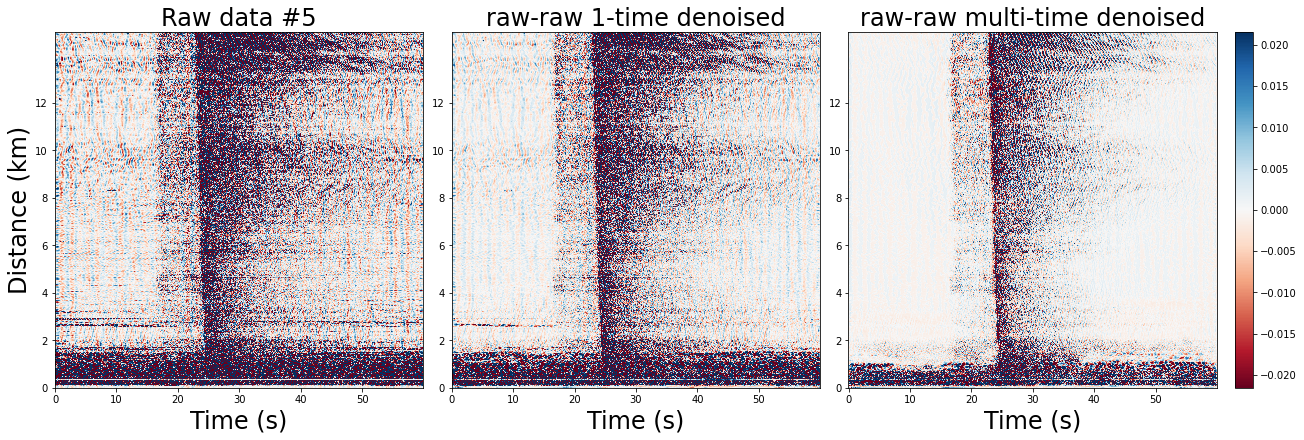

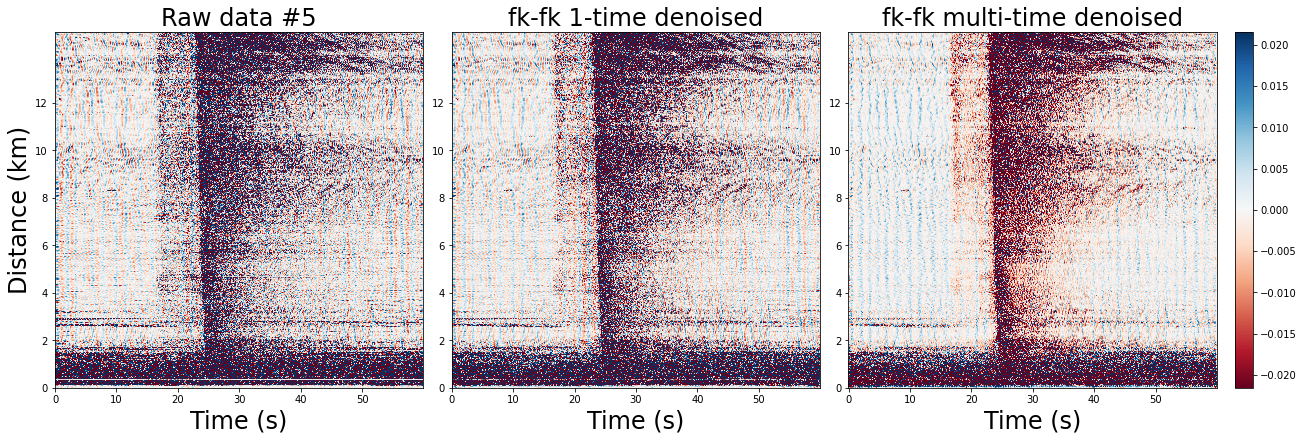

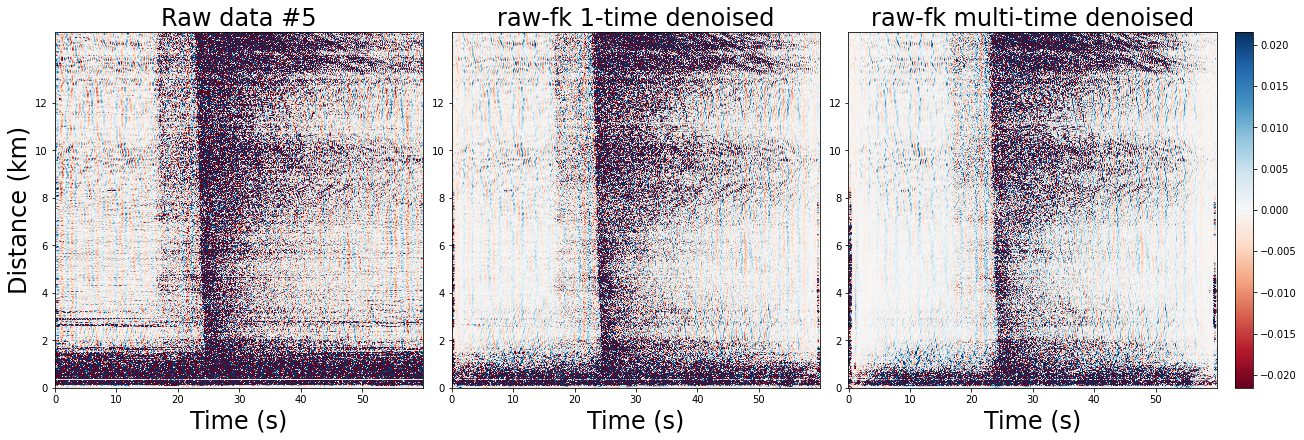

In [107]:
""" select images using the index list """
vizRawDenoise(in_data, oneDenoise_1, mulDenoise_1, index=[5], model="raw-raw")
vizRawDenoise(in_data, oneDenoise_2, mulDenoise_2, index=[5], model="fk-fk")
vizRawDenoise(in_data, oneDenoise_3, mulDenoise_3, index=[5], model="raw-fk")

# Apply to 1-min real-time data
1. Input 2D data, because we assume it is for 1 event
2. Output will be 2D

In [108]:
""" what data to denoise """
in_data = filtered_data[:,:,:]
print(in_data.shape)
# in_data = filtered_data[0,:4000,200:1000]

(180, 6000, 1500)


In [109]:
""" apply the denoisers """
mulDenoise_1=np.zeros(shape=(in_data.shape))
oneDenoise_1=np.zeros(shape=(in_data.shape))
for ievt in range(in_data.shape[0]):
    oneDenoise_1[ievt,:,:], mulDenoise_1[ievt,:,:] = Denoise_largeDAS(in_data[ievt,:,:], model_raw2raw, devc, norm_batch=True)
#     oneDenoise_2, mulDenoise_2 = Denoise_largeDAS(in_data, model_fk2fk, devc)
#     oneDenoise_3, mulDenoise_3 = Denoise_largeDAS(in_data, model_raw2fk, devc, repeat=2, norm_batch=True)

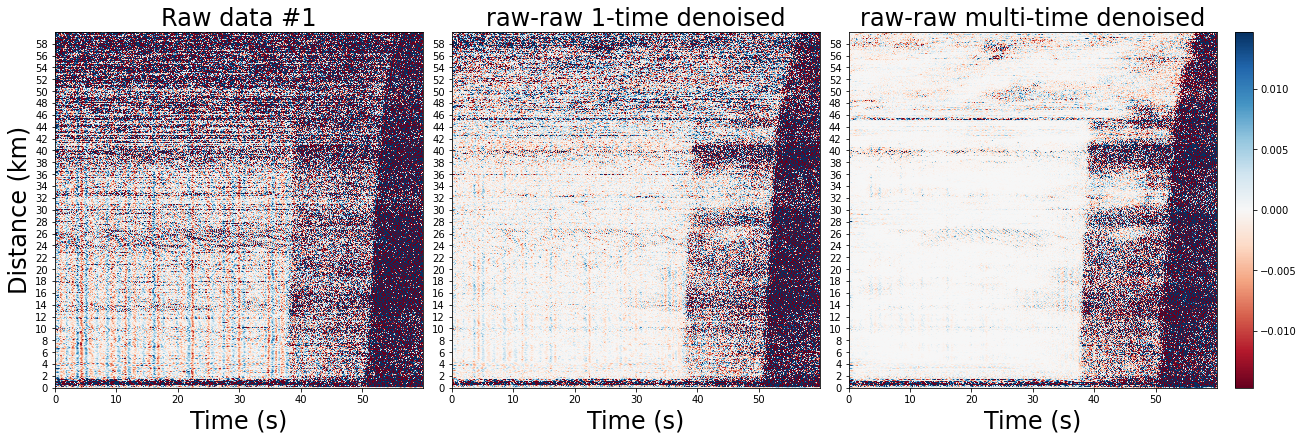

In [110]:
""" select images using the index list """
vizRawDenoise(in_data[:,:,:], oneDenoise_1[:,:,:], mulDenoise_1[:,:,:]*2, index=[1], model="raw-raw")
# vizRawDenoise(in_data[np.newaxis,:,:], oneDenoise_2[np.newaxis,:,:], mulDenoise_2[np.newaxis,:,:], index=[0], model="fk-fk")
# vizRawDenoise(in_data[np.newaxis,:,:], oneDenoise_3[np.newaxis,:,:], mulDenoise_3[np.newaxis,:,:], index=[0], model="raw-fk")

## Time to pick!

In [111]:
# ML picker parameters
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05
fqmin = 0.1
fqmax = 5

dt = 0.001; fs = 100
nfqs = 10
nt = 6000; nc = 3
fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

In [50]:
# download models
pretrain_list = ["ethz","instance","scedc","stead","geofon","neic"]
# pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

list_models = [pn_ethz_model,pn_scedc_model,pn_neic_model,pn_geofon_model,pn_stead_model,pn_instance_model]

In [51]:
pn_ethz_model.to(devc);
pn_scedc_model.to(devc);
pn_neic_model.to(devc);
pn_geofon_model.to(devc);
pn_stead_model.to(devc);
pn_instance_model.to(devc);

Resample the data to 100Hz.

We will consider the first 100 events with Nevent.

In [52]:
Nevent=100

In [112]:
mulDenoise_1.shape

(180, 6000, 1500)

In [113]:
from scipy.interpolate import interp1d

in_data = filtered_data[:,:,:]
# interpolate the raw data
interpolation_function = interp1d(np.linspace(0, 1, 1500), in_data[:,:,:], axis=2, kind='linear')
interpolated_image = interpolation_function(np.linspace(0, 1, 6000))

The denoised image is 1500x1500 points. There are Nevent events.

In [114]:
# interpolate the denoised data.
interpolation_function = interp1d(np.linspace(0, 1, 1500), mulDenoise_1[:,:,:], axis=2, kind='linear')
interpolated_denoised = interpolation_function(np.linspace(0, 1, 6000))

In [115]:
# check that the dimension of the interpolated waveform data is the same.
print(interpolated_image.shape)
print(interpolated_denoised.shape)

(180, 6000, 6000)
(180, 6000, 6000)


In [57]:


# def apply_mbf(DAS_data, list_models, MBF_paras, paras_semblance, \
#               thr=0.01,device=torch.device("cpu")):
#     """"
#     This function takes a array of stream, a list of stations, a list of ML
#     models and apply these models to the data, predict phase picks, and
#     return an array of picks .
#     DAS_data: NDArray of DAS data: [channel,time stamp - 6000]
#     """
#     twin = 6000
#     nsta = DAS_data.shape[0]
#     bigS = np.zeros(shape=(DAS_data.shape[0],3,DAS_data.shape[1]))
#     for i in range(nsta):
#         bigS[i,0,:] = DAS_data[i,:]
#         bigS[i,1,:] = np.zeros(twin)
#         bigS[i,2,:] = np.zeros(twin)

#     # allocating memory for the ensemble predictions
#     batch_pred_P =np.zeros(shape=(len(list_models),nsta,twin)) 
#     batch_pred_mbf_P =np.zeros(shape=(len(list_models),nsta,twin))
#     batch_pred_S =np.zeros(shape=(len(list_models),nsta,twin)) 
#     batch_pred_mbf_S =np.zeros(shape=(len(list_models),nsta,twin))
#     # evaluate
#     for imodel in list_models:
#         imodel.eval()
        
        
#     ######### Broadband workflow ################
#     crap2 = bigS.copy()
#     crap2 -= np.mean(crap2, axis=-1, keepdims= True) # demean data
#     # original use std norm
#     data_std = crap2 / np.std(crap2) + 1e-10
#     # could use max data
#     mmax = np.max(np.abs(crap2), axis=-1, keepdims=True)
#     data_max = np.divide(crap2 , mmax,out=np.zeros_like(crap2), where=mmax!=0)
#     data_tt = torch.Tensor(data_max)
#     # batch predict picks.
#     for ii, imodel in enumerate(list_models):
#         batch_pred_P[ii, :, :] = imodel(data_tt.to(device))[1].detach().cpu().numpy()[:, :]
#         batch_pred_S[ii, :, :] = imodel(data_tt.to(device))[2].detach().cpu().numpy()[:, :]

#     print("Picks predicted in broadband workflow")
    
#     ############# Multi-band Workflow ########
#     windows_std = np.zeros(shape=(nsta, MBF_paras["nfqs"], 3, twin), dtype= np.float32)
#     windows_max = np.zeros(shape=( nsta, MBF_paras["nfqs"], 3, twin), dtype= np.float32)
#     _windows = bigS.copy();#np.zeros(shape=(nsta, 3, twin), dtype= np.float32)
#     _windows_mb = np.zeros(shape=(nsta, 3, MBF_paras["nfqs"], twin), dtype= np.float32)
#     # MB filter
#     for ista in range(nsta): # loop over stations, it should be one in this benchmark test
# #         for icha in range(3): # loop over channel, there should be 3 channels total
#         _windows_mb[ista, 0, :, :] = MB_filter(_windows[ista, 0], MBF_paras)
            
# #         _windows_mb[ista, 1, :, :] = np.zeros(shape=( nsta, MBF_paras["nfqs"], 3, twin), dtype= np.float32)
# #         print(ista," filtered the single channel - rest is zero")
#     _windows_mb = _windows_mb.swapaxes(1, 2)
#     for ista in range(nsta):
#         for ifreq in range(MBF_paras["nfqs"]):
#             # original use std norm
#             windows_std[ista, ifreq,:, :] = _windows_mb[ista, ifreq, :]  \
#                 / np.std(_windows_mb[ista, ifreq, :]) + 1e-10
#             # others use max norm
#             mmax = np.max(np.abs(_windows_mb[ista ,ifreq , :, :]), axis=-1, keepdims=True)
#             windows_max[ista, ifreq,:, :] = np.divide(_windows_mb[ista, ifreq, :, :] \
#                     ,mmax,out=np.zeros_like(_windows_mb[ista, ifreq, :]), where=mmax!=0)
#     # print("now predicting on MBF")
#     batch_pred_mbf_freq_P =np.zeros(shape=(len(list_models),MBF_paras["nfqs"],nsta,twin))
#     batch_pred_mbf_freq_S =np.zeros(shape=(len(list_models),MBF_paras["nfqs"],nsta,twin))
#     for ifreq in range(MBF_paras["nfqs"]):
#         # convert numpy array to torch tensor
#         data_tt_mbf = torch.Tensor(windows_max[:,ifreq,:,:])
#         # batch predict picks.
#         for ii,imodel in enumerate(list_models):
#             batch_pred_mbf_freq_P[ii,ifreq,:, :] = imodel(data_tt_mbf.to(device))[1].detach().cpu().numpy()[:, :]
#             batch_pred_mbf_freq_S[ii,ifreq,:, :] = imodel(data_tt_mbf.to(device))[2].detach().cpu().numpy()[:, :]

#     # take the max at each frequency
#     for ista in range(nsta):
#         for it in range(twin):
#             for ii,imodel in enumerate(list_models):
#                 batch_pred_mbf_P[ii, ista, it] =  np.max(batch_pred_mbf_freq_P[ii, :, ista, it])
#                 batch_pred_mbf_S[ii, ista, it] =  np.max(batch_pred_mbf_freq_S[ii, :, ista, it])
    
    
    
#     print("Picks predicted in MBF workflow")
    
    
    
    
    
# #     smb_pred_S = np.zeros([nsta, twin], dtype = np.float32)
# #     smb_pred_mbf_S = np.zeros([nsta, twin], dtype = np.float32)
# #     smb_pred_P = np.zeros([nsta, twin], dtype = np.float32)
# #     smb_pred_mbf_P = np.zeros([nsta, twin], dtype = np.float32)
#     smb_peak = np.zeros([nsta,2], dtype = np.float32)
#     smb_peak_mbf = np.zeros([nsta,2], dtype = np.float32)

#     # Pick the phase. 
#     # all waveforms are aligned to the reference picks.
#     # so all pick measurements will be made relative to the reference pick
#     # all waveforms starts - 15s from reference picks
#     # allow for +/- 10 seconds around reference picks.
#     sfs = MBF_paras["fs"]
#     istart = 125 # this is because of the FK filter issue.
# #     iend = np.min((t_before*sfs + t_around*sfs,smb_pred.shape[1]))
#     for ista in range(nsta):# should be 1 in this context
        
        
#         ### BROADBAND ELEP
#         # 0 for P-wave
#         smb_pred = ensemble_semblance(batch_pred_P[:, ista, :],\
#                                              paras_semblance)
#         imax = np.argmax(smb_pred[istart:]) 
#         # print("max probab",smb_pred[ista,imax+istart])
#         if smb_pred[imax+istart] > thr:
#             smb_peak[ista,0] = float((imax)/sfs)+istart/sfs #-t_around
            
#         # 1 for S-wave
#         smb_pred = ensemble_semblance(batch_pred_S[:, ista, :],\
#                                              paras_semblance)
#         imax = np.argmax(smb_pred[istart:]) 
#         # print("max probab",smb_pred[ista,imax+istart])
#         if smb_pred[imax+istart] > thr:
#             smb_peak[ista,1] = float((imax)/sfs)+istart/sfs #-t_around
 
#         ### MBF ELEP
#         # 0 for P-wave
#         smb_pred_mbf = ensemble_semblance(batch_pred_mbf_P[:, ista, :], paras_semblance)
#         imax = np.argmax(smb_pred_mbf[ istart : ])
#         if smb_pred_mbf[ imax+istart] > thr:
#             smb_peak_mbf[ista,0] = float(imax/sfs)+istart/sfs
            
            
#         # 1 for S-wave
#         smb_pred_mbf = ensemble_semblance(batch_pred_mbf_S[:, ista, :], paras_semblance)
#         imax = np.argmax(smb_pred_mbf[ istart : ])
#         if smb_pred_mbf[ imax+istart] > thr:
#             smb_peak_mbf[ista,1] = float(imax/sfs)+istart/sfs
            

#     # below return the time of the first pick aas a list over stations
#     return smb_peak, smb_peak_mbf


## Apply Phase Picking

apply ELEP MBF picking below as a loop over events.

Select max number of channels with Nchanmax during debugging.

Plot the picks and save the plots.


Todo:
* Assign start time of each event data and save into dataframe
* store picks in data frame
* Assign good quality picks from low quality picks to disregard picks

In [58]:
# crap=np.zeros((interpolated_image.shape[1],interpolated_image.shape[2]))
# Nchanmax=300
# for i in range(5):#interpolated_image.shape[0]):
    
#     pick,pick_mbf=  apply_mbf(interpolated_image[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
#     max_amp = np.median(np.fabs(interpolated_image[i,:Nchanmax,:]))*2
#     x, y = np.arange(interpolated_image[i,:Nchanmax,:].shape[1]), np.arange(interpolated_image[i,:Nchanmax,:].shape[0])
#     plt.figure()
#     plt.pcolormesh(x/fs, y*dchan/1000,interpolated_image[i,:Nchanmax,:],\
#                    shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
#                   alpha=0.7)
#     plt.xlabel("Time since starttime (s)")
#     plt.ylabel("Distance along cable (km)")
#     plt.scatter(pick[:,0],y*dchan/1000,s=12,marker='o',c="b")
#     plt.scatter(pick[:,1],y*dchan/1000,s=12,marker='o',c="r")
#     plt.scatter(pick_mbf[:,0],y*dchan/1000,s=36,marker='x',c="k")
#     plt.scatter(pick_mbf[:,1],y*dchan/1000,s=36,marker='x',c="g")
#     plt.title("Ensemble Picking on Raw data")
#     plt.savefig(f"./raw_ELEP_picks_event_{i}.png")
#     plt.show()
    
    
#     colors = ['blue', 'green', 'orange', 'yellow']
#     labels = ['P BB', 'S BB', 'P MBF', 'S MBF']
#     labels2 = ['P MBF', 'S MBF','P BB', 'S BB']
#     plt.figure()
#     plt.hist(pick_mbf[:,0],bins=10,alpha=0.5,color=colors[2],label=labels[2])
#     plt.hist(pick_mbf[:,1],bins=10,alpha=0.5,color=colors[3],label=labels[3])
#     plt.hist(pick[:,0],bins=10,alpha=0.5,color=colors[0],label=labels[0])
#     plt.hist(pick[:,1],bins=10,alpha=0.5,color=colors[1],label=labels[1])
#     plt.title("Picks histograms")
#     plt.legend(labels2)
#     plt.xlabel("Time since starttime (s)")
#     plt.savefig(f"./hist_raw_ELEP_picks_event_{i}.png")
#     plt.show()
    
    
#     pick,pick_mbf=  apply_mbf(interpolated_denoised[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
#     max_amp = np.median(np.fabs(interpolated_denoised[i,:Nchanmax,:]))*2
#     x, y = np.arange(interpolated_denoised[i,:Nchanmax,:].shape[1]), np.arange(interpolated_denoised[i,:Nchanmax,:].shape[0])
    
#     plt.figure()
#     plt.pcolormesh(x/fs, y*dchan/1000,interpolated_denoised[i,:Nchanmax,:], \
#                    shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
#                   alpha=0.7)
#     plt.xlabel('Time since starttime (s)')
#     plt.ylabel("Distance along cable (km)")
#     plt.scatter(pick[:,0],y*dchan/1000,s=12,marker='o',c="b")
#     plt.scatter(pick[:,1],y*dchan/1000,s=12,marker='o',c="r")
#     plt.scatter(pick_mbf[:,0],y*dchan/1000,s=36,marker='x',c="k")
#     plt.scatter(pick_mbf[:,1],y*dchan/1000,s=36,marker='x',c="g")
#     plt.title("Ensemble Picking on Denoised data")
#     plt.savefig(f"./denoised_ELEP_picks_event_{i}.png")
#     plt.show()
    
    
#     plt.hist(pick_mbf[:,0],bins=10,alpha=0.5,color=colors[2],label=labels[2])
#     plt.hist(pick_mbf[:,1],bins=10,alpha=0.5,color=colors[3],label=labels[3])
#     plt.hist(pick[:,0],bins=10,alpha=0.5,color=colors[0],label=labels[0])
#     plt.hist(pick[:,1],bins=10,alpha=0.5,color=colors[1],label=labels[1])
#     plt.title("Picks histograms")
#     plt.xlabel("Time since starttime (s)")
#     plt.legend(labels2)
#     plt.savefig(f"./hist_denoised_ELEP_picks_event_{i}.png")
#     plt.show()


After experimenting, we find that the MBF workflow is much less stable than the BB ensemble workflow. It could be due to the linear interpolation we had to do to input into the eqT.

In the following, we modify the apply_mbf function to not do the MBF filter and apply it again on the raw and denoised data.

In [116]:
def apply_elep(DAS_data, list_models, MBF_paras, paras_semblance, \
              thr=0.01,device=torch.device("cpu")):
    """"
    This function takes a array of stream, a list of stations, a list of ML
    models and apply these models to the data, predict phase picks, and
    return an array of picks .
    DAS_data: NDArray of DAS data: [channel,time stamp - 6000]
    """
    twin = 6000
    nsta = DAS_data.shape[0]
    bigS = np.zeros(shape=(DAS_data.shape[0],3,DAS_data.shape[1]))
    for i in range(nsta):
        bigS[i,0,:] = DAS_data[i,:]
        bigS[i,1,:] = np.zeros(twin)
        bigS[i,2,:] = np.zeros(twin)

    # allocating memory for the ensemble predictions
    batch_pred_P =np.zeros(shape=(len(list_models),nsta,twin)) 
    batch_pred_S =np.zeros(shape=(len(list_models),nsta,twin)) 
    # evaluate
    for imodel in list_models:
        imodel.eval()
        
        
    ######### Broadband workflow ################
    crap2 = bigS.copy()
    crap2 -= np.mean(crap2, axis=-1, keepdims= True) # demean data
    # original use std norm
    data_std = crap2 / np.std(crap2) + 1e-10
    # could use max data
    mmax = np.max(np.abs(crap2), axis=-1, keepdims=True)
    data_max = np.divide(crap2 , mmax,out=np.zeros_like(crap2), where=mmax!=0)
    data_tt = torch.Tensor(data_max)
    # batch predict picks.
    for ii, imodel in enumerate(list_models):
        batch_pred_P[ii, :, :] = imodel(data_tt.to(device))[1].detach().cpu().numpy()[:, :]
        batch_pred_S[ii, :, :] = imodel(data_tt.to(device))[2].detach().cpu().numpy()[:, :]

    print("Picks predicted in broadband workflow")
    
    smb_peak = np.zeros([nsta,2], dtype = np.float32)

    # Pick the phase. 
    # all waveforms are aligned to the reference picks.
    # so all pick measurements will be made relative to the reference pick
    # all waveforms starts - 15s from reference picks
    # allow for +/- 10 seconds around reference picks.
    sfs = MBF_paras["fs"]
    istart = 125 # this is because of the FK filter issue.
#     iend = np.min((t_before*sfs + t_around*sfs,smb_pred.shape[1]))
    for ista in range(nsta):# should be 1 in this context
        
        
        ### BROADBAND ELEP
        # 0 for P-wave
        smb_pred = ensemble_semblance(batch_pred_P[:, ista, :],\
                                             paras_semblance)
        imax = np.argmax(smb_pred[istart:]) 
        # print("max probab",smb_pred[ista,imax+istart])
        if smb_pred[imax+istart] > thr:
            smb_peak[ista,0] = float((imax)/sfs)+istart/sfs #-t_around
            
        # 1 for S-wave
        smb_pred = ensemble_semblance(batch_pred_S[:, ista, :],\
                                             paras_semblance)
        imax = np.argmax(smb_pred[istart:]) 
        # print("max probab",smb_pred[ista,imax+istart])
        if smb_pred[imax+istart] > thr:
            smb_peak[ista,1] = float((imax)/sfs)+istart/sfs #-t_around
 
    # below return the time of the first pick aas a list over stations
    return smb_peak


With the newly defined function - now apply to all data

Picks predicted in broadband workflow


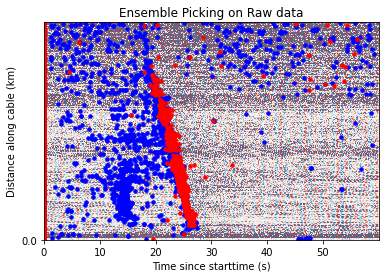

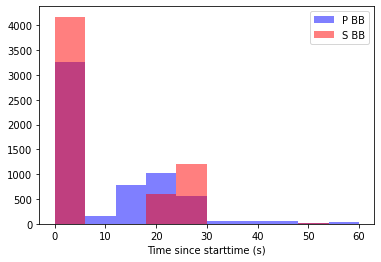

Picks predicted in broadband workflow


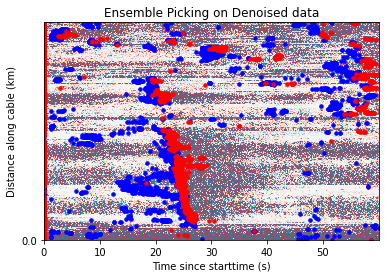

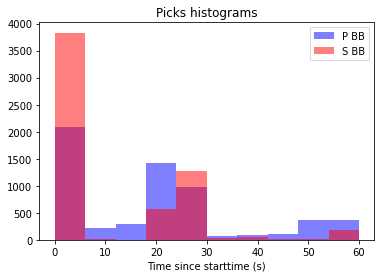

Number of zeros picked in P 3155 1801.0 (raw+denoised) and S 4175 3809.0 (raw+denoised)
Mean picked in P 20.69 26.83 (raw+denoised) and S 24.47 27.75 (raw+denoised) 
Standard deviation in P 8.84 14.71 (raw+denoised) and S 14.71 10.17 (raw+denoised)
 
 
 
Picks predicted in broadband workflow


In [ ]:
crap=np.zeros((interpolated_image.shape[0],interpolated_image.shape[1]))
Nchanmax=6000
Nevent=100
nzeros_p = np.zeros(Nevent,dtype=np.int32)
mean_p = np.zeros(Nevent)
std_p = np.zeros(Nevent)
nzeros_s = np.zeros(Nevent,dtype=np.int32)
mean_s = np.zeros(Nevent)
std_s = np.zeros(Nevent)

nzeros_p_denoised = np.zeros(Nevent)
mean_p_denoised  = np.zeros(Nevent)
std_p_denoised  = np.zeros(Nevent)
nzeros_s_denoised  = np.zeros(Nevent)
mean_s_denoised  = np.zeros(Nevent)
std_s_denoised  = np.zeros(Nevent)
for i in range(20):#interpolated_image.shape[0]):

    pick=  apply_elep(interpolated_image[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
    max_amp = np.median(np.fabs(interpolated_image[i,:Nchanmax,:]))*2
    x, y = np.arange(interpolated_image[i,:Nchanmax,:].shape[1]), np.arange(interpolated_image[i,:Nchanmax,:].shape[0])
#     pick=  apply_elep(interpolated_image[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
#     max_amp = np.median(np.fabs(interpolated_image[i,:Nchanmax,:]))*2
#     x, y = np.arange(interpolated_image[i,:Nchanmax,:].shape[1]), np.arange(interpolated_image[i,:Nchanmax,:].shape[0])
    plt.figure()
    plt.pcolormesh(x/fs, y*dchan/1000,interpolated_image[i,:Nchanmax,:],\
                   shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
                  alpha=0.7)
#     plt.pcolormesh(x/fs, y*dchan/1000,interpolated_image[i,:Nchanmax,:],\
#                    shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
#                   alpha=0.7)
    plt.xlabel("Time since starttime (s)")
    plt.ylabel("Distance along cable (km)")
    plt.yticks(np.arange(0, Nchanmax, Nchanmax/5), np.arange(0, Nchanmax, Nchanmax/5)*dchan/1000)
    plt.scatter(pick[:,0],y*dchan/1000,s=12,marker='o',c="b")
    plt.scatter(pick[:,1],y*dchan/1000,s=12,marker='o',c="r")
    plt.title("Ensemble Picking on Raw data")
    plt.savefig(f"./raw_ELEP_bb_picks_event_{i}.png")
    plt.show()
    
    # get statistical measures of these picks.
    # first only look at non zeros
    nzeros_p[i] = len(pick[pick[:,0]==0,0])
    mean_p[i] = np.mean(pick[pick[:,0]!=0,0])
    std_p[i] = np.std(pick[pick[:,0]!=0,0])
    nzeros_s[i] = len(pick[pick[:,1]==0,1])
    mean_s[i] = np.mean(pick[pick[:,1]!=0,1])
    std_s[i] = np.std(pick[pick[:,1]!=0,1])
    
    
    colors = ['blue', 'red']
    labels = ['P BB', 'S BB']
    plt.figure()
    plt.hist(pick[:,0],bins=10,alpha=0.5,color=colors[0],label=labels[0],range=(0,60))
    plt.hist(pick[:,1],bins=10,alpha=0.5,color=colors[1],label=labels[1],range=(0,60))
#     plt.title(f"Picks histograms std P {%d}",(mean_p_p))
    plt.legend(labels)
    plt.xlabel("Time since starttime (s)")
    plt.savefig(f"./hist_raw_ELEP_bb_picks_event_{i}.png")
    plt.show()
    
   
    pickd=  apply_elep(interpolated_denoised[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
    max_amp = np.median(np.fabs(interpolated_denoised[i,:Nchanmax,:]))*2
    x, y = np.arange(interpolated_denoised[i,:Nchanmax,:].shape[1]), np.arange(interpolated_denoised[i,:Nchanmax,:].shape[0])
    

#     pick=  apply_elep(interpolated_denoised[i,:Nchanmax,:], list_models, MBF_paras, paras_semblance,thr=0.01,device=devc)       
#     max_amp = np.median(np.fabs(interpolated_denoised[i,:Nchanmax,:]))*2
#     x, y = np.arange(interpolated_denoised[i,:Nchanmax,:].shape[1]), np.arange(interpolated_denoised[i,:Nchanmax,:].shape[0])
    
    plt.figure()
    plt.pcolormesh(x/fs, y*dchan/1000,interpolated_denoised[i,:Nchanmax,:], \
                   shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
                  alpha=0.7)
#     plt.pcolormesh(x/fs, y*dchan/1000,interpolated_denoised[i,:Nchanmax,:], \
#                    shading='auto', vmin=-max_amp, vmax=max_amp, cmap=cmap,\
#                   alpha=0.7)
    plt.xlabel('Time since starttime (s)')
    plt.ylabel("Distance along cable (km)")
    plt.yticks(np.arange(0, Nchanmax, Nchanmax/5), np.arange(0, Nchanmax, Nchanmax/5)*dchan/1000)
    plt.scatter(pickd[:,0],y*dchan/1000,s=12,marker='o',c="b")
    plt.scatter(pickd[:,1],y*dchan/1000,s=12,marker='o',c="r")
    plt.title("Ensemble Picking on Denoised data")
    plt.savefig(f"./denoised_ELEP_bb_picks_event_{i}.png")
    plt.show()
    
    
    nzeros_p_denoised[i] = len(pick[pickd[:,0]==0,0])
    mean_p_denoised[i] = np.mean(pickd[pickd[:,0]!=0,0])
    std_p_denoised[i] = np.std(pickd[pickd[:,0]!=0,0])
    nzeros_s_denoised[i] = len(pickd[pickd[:,1]==0,1])
    mean_s_denoised[i] = np.mean(pickd[pickd[:,1]!=0,1])
    std_s_denoised[i] = np.std(pickd[pickd[:,1]!=0,1])
    
    
    
    plt.hist(pickd[:,0],bins=10,alpha=0.5,color=colors[0],label=labels[0],range=(0,60))
    plt.hist(pickd[:,1],bins=10,alpha=0.5,color=colors[1],label=labels[1],range=(0,60))
    plt.title("Picks histograms")
    plt.xlabel("Time since starttime (s)")
    plt.legend(labels)
    plt.savefig(f"./hist_denoised_ELEP_bb_picks_event_{i}.png")
    plt.show()
    
    print("Number of zeros picked in P {} {} (raw+denoised) and S {} {} (raw+denoised)".format(
          nzeros_p[i] ,nzeros_p_denoised[i] ,nzeros_s[i] ,nzeros_s_denoised[i] ))
    print("Mean picked in P {:.2f} {:.2f} (raw+denoised) and S {:.2f} {:.2f} (raw+denoised) ".format(
          mean_p[i] ,mean_p_denoised[i] ,mean_s[i] ,mean_s_denoised[i] ))
    print("Standard deviation in P {:.2f} {:.2f} (raw+denoised) and S {:.2f} {:.2f} (raw+denoised)".format(
          std_p[i] ,std_p_denoised[i] ,std_p_denoised[i] ,std_s_denoised[i] ))
    

    
    pdict = {'Event_ID':i*np.ones(len(pick[:,1])),'channel_ID':np.arange(0,len(pick[:,1])),\
             'P_picks_raw':pick[:,0],'S_picks_raw':pick[:,1],\
             'P_picks_denoised':pickd[:,0],'S_picks_denoised':pickd[:,1]}
    
    
    
    ddict = {'nzeros_p':nzeros_p[:i],'nzeros_s':nzeros_s[:i],\
             'nzeros_p_denoised':nzeros_p_denoised[:i],'nzeros_s_denoised':nzeros_s_denoised[:i],\
            'mean_p':mean_p[:i],'nzeros_s':mean_s[:i],\
             'mean_p_denoised':mean_p_denoised[:i],'mean_s_denoised':mean_s_denoised[:i],\
            'std_p':std_p[:i],'std_s':std_s[:i],\
             'std_p_denoised':std_p_denoised[:i],'std_s_denoised':std_s_denoised[:i]}
    
    df=pd.DataFrame.from_dict(ddict)
    df.to_csv("performance_metrics_denoising_picking.csv")
    dfp=pd.DataFrame.from_dict(pdict)
    dfp.to_csv("elep_picks.csv")
    print(" ")
    print(" ")
    print(" ")


In [131]:

    pdict = {'Event_ID':i*np.ones(len(pick[:,1])),'channel_ID':np.arange(0,len(pick[:,1])),\
             'P_picks_raw':pick[:,0],'S_picks_raw':pick[:,1],\
             'P_picks_denoised':pick[:,0],'S_picks_denoised':pickd[:,1]}
    

NameError: name 'pickd' is not defined